In [125]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [126]:
# Deep Q Network
class DQNet(nn.Module):
    def __init__(self):
        super(DQNet,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(64*8*8,256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256,4)

    def forward(self,x):
        x = x.view(-1,1,8,8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [127]:
class ReplayBuffer:
    # 初始化缓冲区
    def __init__(self,capacity):
        self.capacity = capacity
        self.buffer = []

    # 将一条经验数据添加到缓冲区中
    def push(self,state,action,reward,next_state,done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((state,action,reward,next_state,done))

    # 随机从缓冲区抽取batch_size大小的经验数据
    def sample(self,batch_size):
        states,actions,rewards,next_states,dones = zip(*random.sample(self.buffer,batch_size))
        return states,actions,rewards,next_states,dones

    def __len__(self):
        return len(self.buffer)

In [128]:
class DQNAgent:
    def __init__(self,state_size,action_size):
        self.state_size = state_size  # 状态空间
        self.action_size = action_size # 动作空间
        self.q_net = DQNet()  # 估计动作价值 神经网络
        self.target_q_net = DQNet() # 计算目标值 神经网络
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(),lr=0.001)  # 初始化Adam优化器
        self.memory = ReplayBuffer(capacity=10000)  # 经验回放缓冲区
        self.gamma = 0.99 # 折扣因子
        self.epsilon = 1.0 # 探索率
        self.epsilon_decay = 0.99995 # 衰减因子
        self.epsilon_min = 0.01 # 探索率最小值
        self.batch_size = 64  # 经验回放每个批次大小
        self.update_rate = 200 # 网络更新频率
        self.steps = 0 # 总步数

    # 探索策略 在给定状态下采取动作
    def get_action(self,state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size) # 随机选择动作
        state = torch.from_numpy(state).float().unsqueeze(0)
        q_values = self.q_net(state)
        return torch.argmax(q_values,dim=1).item()

    # 将状态转移元组存储到经验回放缓冲区
    def remember(self,state,action,reward,next_state,done):
        self.memory.push(state,action,reward,next_state,done)

    # 从经验回放缓冲区抽取一个批次的转移样本
    def relay(self):
        if len(self.memory) < self.batch_size:
            return

        # 从回放经验中抽取数据
        states,actions,rewards,next_states,dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(np.array(states)).float()
        actions = torch.from_numpy(np.array(actions)).long()
        rewards = torch.from_numpy(np.array(rewards)).float()
        next_states = torch.from_numpy(np.array(next_states)).float()
        dones = torch.from_numpy(np.array(dones)).long()

        q_targets = self.target_q_net(next_states).detach()  # 计算下一状态Q值
        q_targets[dones] = 0.0 # 对于已完成状态 将Q值设置为0

        # 计算目标Q值
        q_targets = rewards.unsqueeze(1) + self.gamma * torch.max(q_targets,dim=1)[0].unsqueeze(1)
        q_expected = self.q_net(states).gather(1,actions.unsqueeze(1)) # 计算当前状态Q值

        # 计算损失值
        loss = F.mse_loss(q_expected,q_targets)

        # 通过反向传播更新神经网络的参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1

        # 隔一定步数 更新目标网络
        if self.steps % self.update_rate == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        # 更新epsilon值 使得探索时间衰减
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self,env,episodes):
        steps = []
        for episode in range(episodes):
            env.reset(complete=False)
            step = 0
            while True:
                step += 1
                action = self.get_action(env.state)  # 获取动作
                next_state,reward,done = env.step(action)  # 执行动作
                agent.remember(env.state,action,reward,next_state,done)
                agent.relay()
                env.state = next_state  # 更新地图状态
                if done or step > 200:
                    break
            steps.append(step)
        return steps

    def test(self,env):
        step = 0
        while True:
            step += 1
            action = self.get_action(env.state)
            next_state,reward,done = env.step(action)
            env.state = next_state
            if done or step > 1000:
                break

    def save(self,path):
        torch.save(self.q_net.state_dict(),path+"/value_model.pt")
        torch.save(self.target_q_net.state_dict(),path+"/target_model.pt")

    def load(self,path):
        self.q_net.load_state_dict(torch.load(path+"/value_model.pt"))
        self.target_q_net.load_state_dict(torch.load(path+"/target_model.pt"))

In [129]:
class MazeEnv:
    def __init__(self,size):
        self.size = size
        self.actions = [0,1,2,3]
        self.maze,self.start,self.end = self.generate(size)
        self.state = np.expand_dims(self.maze,axis=2).copy()

    def reset(self,complete=False):
        if complete:
            self.maze,self.start,self.end = self.generate(self.size)
        self.state = np.expand_dims(self.maze,axis=2)
        self.position = self.start
        self.goal = self.end
        self.path = [self.start]
        return self.state

    def step(self, action):
        # 执行动作
        next_position = None
        if action == 0 and self.position[0] > 0:
            next_position = (self.position[0]-1, self.position[1])
        elif action == 1 and self.position[0] < self.size-1:
            next_position = (self.position[0]+1, self.position[1])
        elif action == 2 and self.position[1] > 0:
            next_position = (self.position[0], self.position[1]-1)
        elif action == 3 and self.position[1] < self.size-1:
            next_position = (self.position[0], self.position[1]+1)
        else:
            next_position = self.position

        if next_position == self.goal:
            reward = 500
        elif self.maze[next_position] == -1:
            reward = -200
        else:
            reward = -10

        self.position = next_position  # 更新位置
        self.path.append(self.position)  # 加入路径

        next_state = self.state.copy()
        next_state[self.position] = 2 # 标记路径

        done = (self.position == self.goal)  # 判断是否结束
        return next_state, reward, done

    @staticmethod
    # 生成迷宫图像
    def generate(size):
        maze = np.zeros((size, size))
        # Start and end points
        start = (random.randint(0, size-1), 0)
        end = (random.randint(0, size-1), size-1)
        maze[start] = 1
        maze[end] = 1
        # Generate maze walls
        for i in range(size * size):
            x, y = random.randint(0, size-1), random.randint(0, size-1)
            if (x, y) == start or (x, y) == end:
                continue
            if random.random() < 0.2:
                maze[x, y] = -1
            if np.sum(np.abs(maze)) == size*size - 2:
                break
        return maze, start, end

    @staticmethod
    # BFS求出路径
    def solve_maze(maze, start, end):
        size = maze.shape[0]
        visited = np.zeros((size, size))
        solve = np.zeros((size,size))
        queue = [start]
        visited[start[0],start[1]] = 1
        while queue:
            x, y = queue.pop(0)
            if (x, y) == end:
                break
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                nx, ny = x + dx, y + dy
                if nx < 0 or nx >= size or ny < 0 or ny >= size or visited[nx, ny] or maze[nx, ny] == -1:
                    continue
                queue.append((nx, ny))
                visited[nx, ny] = visited[x, y] + 1
        if visited[end[0],end[1]] == 0:
            return solve,[]
        path = [end]
        x, y = end
        while (x, y) != start:
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                nx, ny = x + dx, y + dy
                if nx < 0 or nx >= size or ny < 0 or ny >= size or visited[nx, ny] != visited[x, y] - 1:
                    continue
                path.append((nx, ny))
                x, y = nx, ny
                break

        points = path[::-1]  # 倒序
        for point in points:
            solve[point[0]][point[1]] = 1
        return solve, points

In [130]:
from PIL import Image

def maze_to_image(maze, path):
    size = maze.shape[0]
    img = Image.new('RGB', (size, size), (255, 255, 255))
    pixels = img.load()
    for i in range(size):
        for j in range(size):
            if maze[i, j] == -1:
                pixels[j, i] = (0, 0, 0)
            elif maze[i, j] == 1:
                pixels[j, i] = (0, 255, 0)
    for x, y in path:
        pixels[y, x] = (255, 0, 0)
    return np.array(img)

In [131]:
maze_size = 8
input_shape = (maze_size,maze_size,1)
num_actions = 4
agent = DQNAgent(input_shape,num_actions)
env = MazeEnv(maze_size)

In [132]:
for epoch in range(100):
    steps = agent.train(env,50)

    plt.imshow(maze_to_image(env.maze,[]))
    plt.savefig(f"mazes/{epoch+1}.png")
    plt.clf()

    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Training Steps')
    plt.savefig(f"train/{epoch+1}.png")
    plt.clf()

    solve = maze_to_image(env.maze,env.path)

    plt.imshow(solve)
    plt.savefig(f"solves/{epoch+1}.png")
    plt.clf()

    env.reset(complete=True)

agent.save("model")

<Figure size 640x480 with 0 Axes>

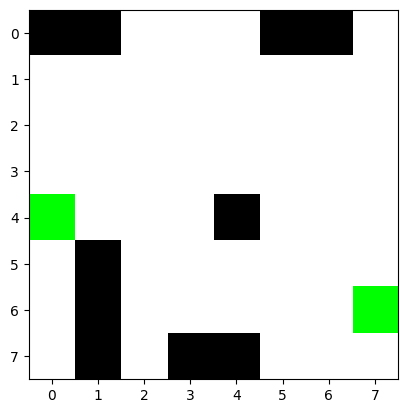

In [136]:
maze = maze_to_image(env.maze,[])
plt.imshow(maze)
plt.show()

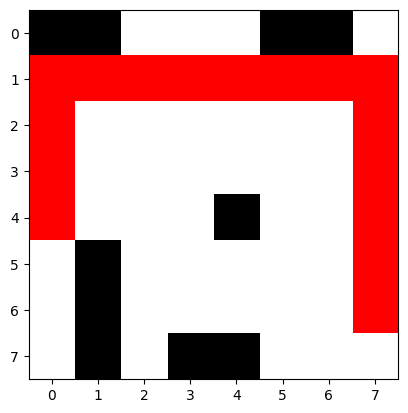

In [135]:
env.reset(complete=True)
agent.test(env)
solve = maze_to_image(env.maze,env.path)
plt.imshow(solve)
plt.show()